In [161]:
import os
import sys
import fitsio
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from   astropy.table import Table
from   scipy.interpolate import interp1d

In [162]:
sys.path.append('{}/DESI'.format(os.environ['HOME']))

In [163]:
import pubplot

from schechter     import schechter, named_schechter
from gama_limits   import gama_field
from delta8_limits import d8_limits, delta8_tier
from findfile      import findfile, fetch_fields
from lumfn         import multifield_lumfn

In [164]:
version = 'GAMA4'
survey  = 'gama'
dryrun  = False

In [165]:
fields = fetch_fields(survey)

In [166]:
# TODO: clean up root below in LF cells
root = '{}/data/GAMA4/'.format(os.environ['HOME'])
#fpath = root + 'gama_gold_ddp_n8.fits'
fpath =  findfile(ftype='ddp_n8', version=version, dryrun=dryrun, survey=survey)
fpath

'/cosma/home/durham/dc-moor2/data/GAMA4/gama_gold_ddp_n8.fits'

In [167]:
#! ls /global/cscratch1/sd/mjwilson/norberg/GAMA4/

In [168]:
#ddps = fits.open(root + '/global/cscratch1/sd/mjwilson/norberg/GAMA4/gama_gold_ddp_n8.fits')
#ddps = fits.open(root+'gama_gold_ddp_n8.fits')

ddps = fits.open(fpath)
ddps = ddps[1].header
#ddps

In [169]:
#! ls /global/cscratch1/sd/mjwilson/desi/BGS/Sam

In [170]:
field = 'G12'

In [171]:
fpath =  findfile(ftype='randoms_bd_ddp_n8', field=field, version=version, dryrun=dryrun, survey=survey)
randoms = Table.read(fpath)
#randoms = Table.read('{}/data/GAMA4/randoms/randoms_bd_ddp_n8_{}_0.fits'.format(os.environ['HOME'], field))

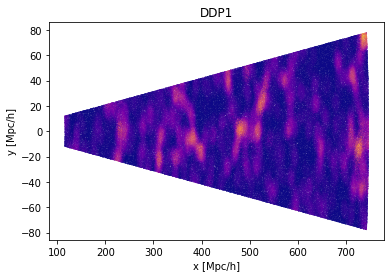

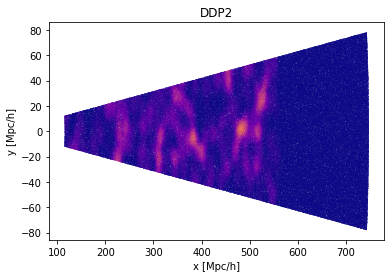

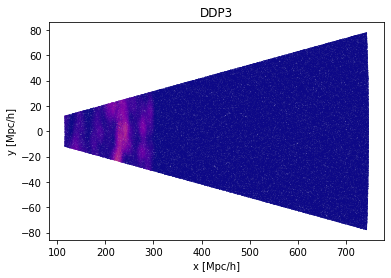

In [172]:
randoms_slice = randoms[np.abs(randoms['ROTCARTESIAN_Z']) < 5.]

for idx in np.arange(1, 4, 1):
    plt.scatter(randoms_slice['ROTCARTESIAN_X'],\
                randoms_slice['ROTCARTESIAN_Y'],\
                c=randoms_slice['DDP{}_DELTA8'.format(idx)],\
                marker='.',\
                lw=0.0,\
                s=1,\
                vmin=-1.,\
                vmax=10.,\
                cmap='plasma')

    pl.xlabel('x [Mpc/h]')
    pl.ylabel('y [Mpc/h]')
    
    plt.title('DDP{}'.format(idx))
    plt.show()

Text(0.5, 1.0, 'G12 GAMA Field')

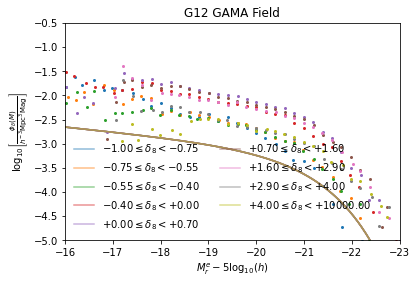

In [173]:
colors   = plt.rcParams['axes.prop_cycle'].by_key()['color']

# TO DO: take from header
for i in np.arange(0, 9, 1):
    
    ddp = Table.read(findfile(ftype='ddp_n8_d0', survey=survey, field=field, version=version, utier=i))
    vmax = Table.read(findfile(ftype='ddp_n8_d0_vmax', survey=survey, field=field, version=version, utier=i), 'VMAX')
    lf = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'LUMFN')
    ref = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'REFERENCE')

    lf   = lf[lf['N'] > 0]

    lims = np.array(list(ddp.meta['D8{}LIMS'.format(i)][1:-1].split(','))).astype(np.float32)

    label = r'${:+.2f} \leq \delta_8 < {:+.2f}$'.format(lims[0], lims[1])

    pl.plot(ref['MS'], np.log10(ref['d{}_REFSCHECHTER'.format(i)]), label=label, alpha=0.5, c=colors[i])
    pl.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', marker='.', lw=0.0, c=colors[i], markersize=4)

plt.xlabel(r'$M_r^e - 5 \log_{10}(h)$')
plt.ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{h^{-3} {\rm Mpc}^{3} {\rm Mag}^{}} \right] $')

pl.xlim(-16., -23.0)
pl.ylim(-5, -0.5)

pl.legend(frameon=False, loc=3, ncol=2, fontsize=10)
pl.title('{} GAMA Field'.format(field))

Text(0.5, 1.0, 'All GAMA Fields')

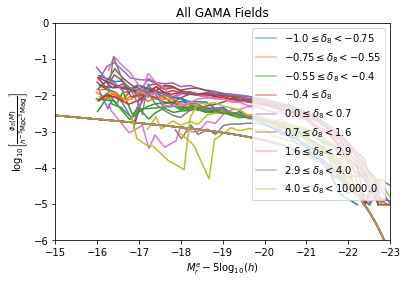

In [174]:
colour   = plt.rcParams['axes.prop_cycle'].by_key()['color']

for field in fields:
    for i in np.arange(0, 9, 1):
        ddp = Table.read(findfile(ftype='ddp_n8_d0', survey=survey, field=field, version=version, utier=i))
        vmax = Table.read(findfile(ftype='ddp_n8_d0_vmax', survey=survey, field=field, version=version, utier=i), 'VMAX')
        lf = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'LUMFN')
        ref = Table.read(findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=i), 'REFERENCE')

        lf   = lf[lf['N'] > 0]

        if field == 'G15':
            if i != 3:
                pl.plot(ref['MS'], np.log10(ref['d{}_REFSCHECHTER'.format(i)]), label=r'${} \leq \delta_8 < {}$'.format(d8_limits[i][0], d8_limits[i][1]), alpha=0.5, c=colour[i])
            else:
                pl.plot(ref['MS'], np.log10(ref['d{}_REFSCHECHTER'.format(i)]), label=r'${} \leq \delta_8$'.format(d8_limits[i][0]), alpha=0.5, c=colour[i])

        else:
            pl.plot(ref['MS'], np.log10(ref['d{}_REFSCHECHTER'.format(i)]), alpha=0.5, c=colour[i])

        pl.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', c=colour[i])

pl.xlabel(r'$M_r^e - 5 \log_{10}(h)$')
pl.ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{h^{-3} {\rm Mpc}^{3} {\rm Mag}^{}} \right] $')

pl.xlim(-15., -23.0)
pl.ylim(-6,   0)

pl.legend(frameon=False, loc=2, ncol=2)
pl.legend()
pl.title('All GAMA Fields')

(array([ 14.,   2., 222., 521., 127., 149., 246., 189., 111.,  83.,  80.,
        167., 200.,  77.,  58.,  81.,  63.,  56.,  96., 191.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 [<matplotlib.patches.Polygon at 0x7f6a7a7d4d30>])

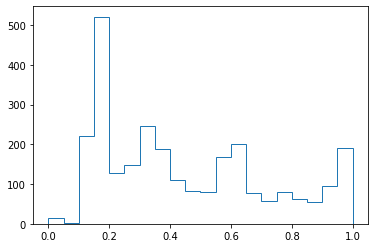

In [175]:
pl.hist(vmax['VZ'] / vmax['VMAX'], histtype='step', bins=np.arange(0., 1.01, 0.05))

In [176]:
#lf.meta

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


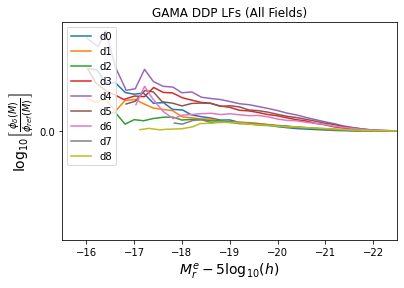

In [186]:
for idx in range(9):
    
    all_fpaths = []
    for field in fields:
        fpath = findfile(ftype='ddp_n8_d0_lumfn', survey=survey, field=field, version=version, utier=idx)
        all_fpaths.append(fpath)
        
    all_fpaths = np.array(all_fpaths)
    result = multifield_lumfn(all_fpaths)
    
    pl.plot(result['MEDIAN_M'], result['PHI_IVMAX'], label='d{}'.format(idx), color=colour[idx])
    
plt.xlabel(r'$M_r^e - 5 \log_{10}(h)$', fontsize=14)
plt.ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{\phi_{ref}(M)} \right]$', fontsize=14)
plt.title(r'{} DDP LFs (All Fields)'.format(survey.upper()))

pl.xlim(-22.5, -15.5)
#pl.ylim(-0.68, 0.68)
pl.ylim(-0.04, 0.04)
pl.gca().invert_xaxis()

pl.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
pl.gca().yaxis.set_major_locator(plt.MultipleLocator(0.2))

pl.legend(frameon=True, loc=2)
pl.show()

/tmp/ipykernel_146386/3860989552.py:24: RuntimeWarning: divide by zero encountered in log10
  pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label='d{}'.format(idx), color=colour[idx])
/tmp/ipykernel_146386/3860989552.py:24: RuntimeWarning: divide by zero encountered in log10
  pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label='d{}'.format(idx), color=colour[idx])
/tmp/ipykernel_146386/3860989552.py:24: RuntimeWarning: divide by zero encountered in log10
  pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label='d{}'.format(idx), color=colour[idx])
/tmp/ipykernel_146386/3860989552.py:24: RuntimeWarning: divide by zero encountered in log10
  pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label='d{}'.format(idx), color=colour[idx])
/tmp/ipykernel_146386/3860989552.py:24: RuntimeWarning: divide by zero encountered in log10
  pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label='d{}'.format(idx), color=colour[idx])
/tmp/ipykernel_146386/3860989552.py:24: RuntimeWarning: divide by zero encountered in log1

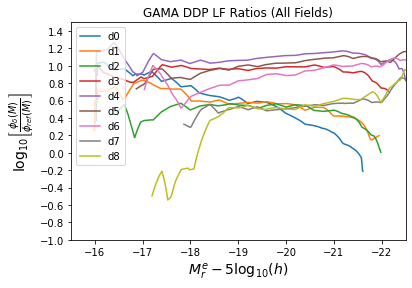

In [190]:
Ms = np.arange(-25.5, -15.5 , 0.1)
bin_centres =  (Ms[1:]+Ms[:-1])/2

# TODO: Re-add multifield_lumfn; make DESI compatible

for idx in range(9):
    LF_G9  = Table.read(root + 'gama_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(idx))
    LF_G12 = Table.read(root + 'gama_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(idx))
    LF_G15 = Table.read(root + 'gama_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(idx))

    LF_G9_ref  = Table.read(root + 'gama_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')
    LF_G12_ref = Table.read(root + 'gama_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')
    LF_G15_ref = Table.read(root + 'gama_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')
    
    LF_G9_curve = interp1d(LF_G9['MEDIAN_M'], LF_G9['PHI_IVMAX'], kind='linear', copy=True, bounds_error=False, fill_value=0.0, assume_sorted=False)
    LF_G12_curve = interp1d(LF_G12['MEDIAN_M'], LF_G12['PHI_IVMAX'], kind='linear', copy=True, bounds_error=False, fill_value=0.0, assume_sorted=False)
    LF_G15_curve = interp1d(LF_G15['MEDIAN_M'], LF_G15['PHI_IVMAX'], kind='linear', copy=True, bounds_error=False, fill_value=0.0, assume_sorted=False)

    
    x=np.c_[LF_G9_ref['MS'], np.array(LF_G9_curve(LF_G9_ref['MS'])/LF_G9_ref['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12_curve(LF_G12_ref['MS'])/LF_G12_ref['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15_curve(LF_G15_ref['MS'])/LF_G15_ref['d{}_REFSCHECHTER'.format(idx)])]
    LF_mean = np.mean(x[:,1:], axis=1)
    LF_std = np.std(x[:,1:], axis=1) / np.sqrt(3)

    pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label='d{}'.format(idx), color=colour[idx])

plt.xlabel(r'$M_r^e - 5 \log_{10}(h)$', fontsize=14)
plt.ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{\phi_{ref}(M)} \right]$', fontsize=14)
plt.title(r'{} DDP LF Ratios (All Fields)'.format(survey.upper()))

pl.xlim(-22.5, -15.5)
pl.ylim(-1, 1.5)
pl.gca().invert_xaxis()

pl.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
pl.gca().yaxis.set_major_locator(plt.MultipleLocator(0.2))

pl.legend(frameon=True, loc=2)
pl.show()

# Done.